In [614]:
current_week = 5

start_year = 2010
current_year = 2024

current_year_week = f"{current_year}_{current_week}"

# Imports

In [572]:
#turns off any warnings
import warnings
warnings.filterwarnings('ignore')

#various modules
import nfl_data_py as nfl
#from sportsreference.nfl.boxscore import Boxscores, Boxscore


import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pickle
import json
import seaborn as sns
import numpy as np
import xgboost as xgb

from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split


import boto3
from decimal import Decimal
from boto3.dynamodb.conditions import Key


#from googleapiclient.discovery import build
#from google.oauth2.service_account import Credentials

In [800]:
import decimal

In [801]:
decimal.__version__

'1.70'

In [573]:
import boto3
from boto3.dynamodb.conditions import Key


dynamodb = boto3.resource('dynamodb', region_name='us-east-1')  

# Bring in data

In [656]:
years = range(start_year - 1, current_year + 1)
true_years = range(start_year, current_year + 1)

pbp = nfl.import_pbp_data(years, downcast=True, cache=False, alt_path=None)
weekly = nfl.import_weekly_data(years, downcast=True)
season = nfl.import_seasonal_data(years, s_type='REG')
#rosetrs = nfl.import_weekly_rosters(years)
injury = nfl.import_injuries(years)
#pass_ratings = nfl.import_weekly_pfr('pass',years)
full_schedule = nfl.import_schedules(true_years)
teams = nfl.import_team_desc()


2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
Downcasting floats.


# Data transformation and feature engineering

In [657]:
pbp['home_team'] = pbp['home_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
pbp['away_team'] = pbp['away_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
pbp['posteam'] = pbp['posteam'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
pbp['defteam'] = pbp['defteam'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})

full_schedule['home_team'] = full_schedule['home_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})
full_schedule['away_team'] = full_schedule['away_team'].replace({'OAK': 'LV', 'SD': 'LAC', 'STL': 'LA'})

In [658]:
pbp['rz'] = np.where(((pbp['defteam'] == pbp['side_of_field']) & ((pbp['yardline_100'] <= 20) | (pbp['yardline_100'] >= 80))), 1, 0)

In [659]:
schedule_columns = ['game_id', 'season', 'week', 'home_team','away_team','weekday', 'home_qb_id', 'away_qb_id', 'home_moneyline','spread_line',
                 'home_spread_odds', 'total_line',  'over_odds', 'roof', 'away_rest', 'home_rest', 'stadium_id', 'div_game', 'gametime', 'gameday']
schedule = full_schedule[schedule_columns].dropna(subset = 'total_line')

In [660]:
def get_implied_totals(row):
    home_points = (row['total_line'] / 2) + (row['spread_line'] / 2)
    away_points = (row['total_line'] / 2) - (row['spread_line'] / 2)
    return pd.Series([home_points, away_points])


In [661]:
schedule[['home_implied_points', 'away_implied_points']] = schedule.apply(get_implied_totals, axis=1)

## Advanced stats

In [662]:
melted_schedule_teams = pd.melt(schedule, id_vars=['season', 'week'], value_vars=['home_team', 'away_team'], value_name='team').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'team']]
melted_schedule_qbs = pd.melt(schedule, id_vars=['season', 'week'], value_vars=['home_qb_id', 'away_qb_id'], value_name='qb_id').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'qb_id']]
melted_schedule = pd.concat([melted_schedule_teams, melted_schedule_qbs['qb_id']], axis=1)

### QBR

In [663]:
def nfl_passer_rating(cmpls, yds, tds, ints):
     """ Defines a function which handles passer rating calculation for the NFL."""
     def _min_max(x, xmin, xmax):

         # Check if x is less than the minimum. If so, return the minimum.
         if x < xmin:
             return xmin
         
         # Check if x is greater than the maximum. If so, return the maximum.
         elif x > xmax:
             return xmax
         
         # Otherwise, just return x. And weep for the future.
         else:
             return x
             
     # Step 0: Make sure these are floats, dammit.
     cmpls = cmpls + 0.0
     yds = yds + 0.0
     tds = tds + 0.0
     ints = ints + 0.0
     
     # Step 1: The completion percentage.         
     step_1 = cmpls - 0.3
     step_1 = step_1 * 5
     step_1 = _min_max(step_1, 0, 2.375)
     
     # Step 2: The yards per attempt.
     step_2 = yds - 3
     step_2 = step_2 * 0.25
     step_2 = _min_max(step_2, 0, 2.375)
     
     # Step 3: Touchdown percentage.
     step_3 = tds * 20
     step_3 = _min_max(step_3, 0, 2.375)
     
     # Step 4: Interception percentage.
     step_4 = ints * 25
     step_4 = 2.375 - step_4
     step_4 = _min_max(step_4, 0, 2.375)
     
     # Step 5: Compute the rating based on the sum of steps 1-4.
     rating = step_1 + step_2 + step_3 + step_4 + 0.0
     rating = rating / 6
     rating = rating * 100
     
     # Step 6: Return the rating, formatted to 1 decimal place, as a Decimal.
     return rating

def calculate_qbr(att, comp, yds, td, ints):

    #replace with college qbr?
    if att == 0:
        return 0

    a = ((comp/att) - 0.3) * 5
    b = ((yds/att) - 3) * 0.25
    c = (td/att) * 20
    d = 2.375 - ((ints/att) * 25)

    for i in [a, b, c, d]:
        if i < 0:
            i = 0
        elif i > 2.375:
            i = 2.375

    passer_rating = ((a + b + c + d) / 6) * 100

    return passer_rating

In [664]:
qbs_weekly = weekly[weekly['position_group']=='QB']
qbs_weekly['passer_rating'] = qbs_weekly.apply(lambda row: nfl_passer_rating(row['completions'], row['passing_yards'], row['passing_tds'], row['interceptions']), axis=1)
qbs_weekly['qbr'] = qbs_weekly.apply(lambda row: calculate_qbr(row['attempts'], row['completions'], row['passing_yards'], row['passing_tds'], row['interceptions']), axis=1)

In [665]:
starting_qbs =  pd.merge(melted_schedule.rename(columns={"qb_id": "player_id"}), qbs_weekly, on=['season', 'week', 'player_id'], how='left').sort_values(by=['player_id', 'season', 'week']).reset_index(drop=True)
first_game = starting_qbs.groupby('player_id').first()[['qbr', 'passer_rating']].mean()

starting_qbs['passer_rating_shifted'] = starting_qbs.groupby('player_id')['passer_rating'].shift()
starting_qbs['qbr_shifted'] = starting_qbs.groupby('player_id')['qbr'].shift()
starting_qbs['player_name'] = starting_qbs.groupby('player_id')['player_name'].shift()

#starting_qbs['passer_rating_shifted'] = starting_qbs['passer_rating_shifted'].fillna(value = first_game['passer_rating'])
starting_qbs['qbr_shifted'] = starting_qbs['qbr_shifted'].fillna(value = first_game['qbr'])

starting_qbs['ewma_passer_rating'] = starting_qbs.groupby('player_id')['passer_rating_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
starting_qbs['ewma_qbr'] = starting_qbs.groupby('player_id')['qbr_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

starting_qbs[(starting_qbs['season'] == 2023) & (starting_qbs['week'] == current_week)][['team', 'player_name', 'passer_rating_shifted', 'qbr_shifted', 'ewma_passer_rating', 'ewma_qbr']].head()

,team,player_name,passer_rating_shifted,qbr_shifted,ewma_passer_rating,ewma_qbr
2972,LA,M.Stafford,118.750000,89.479167,126.537203,86.977694
4197,DEN,R.Wilson,158.333333,133.482143,132.038950,100.810571
4426,MIN,K.Cousins,118.750000,76.425439,134.503854,99.283220
4782,TEN,R.Tannehill,118.750000,98.750000,123.422833,87.462592
5160,NO,D.Carr,118.750000,68.186937,121.339847,79.420585


### EPA per Play

In [666]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()
rushing_defense_epa = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()
passing_offense_epa = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()
passing_defense_epa = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_offense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), rushing_offense_epa, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
rushing_defense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), rushing_defense_epa, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)
passing_offense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), passing_offense_epa, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
passing_defense_epa =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), passing_defense_epa, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)

# # lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values
rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values
passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values
passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

,season,week,team,epa_rushing_offense,epa_shifted_rushing_offense,ewma_rushing_offense,ewma_dynamic_window_rushing_offense,epa_passing_offense,epa_shifted_passing_offense,ewma_passing_offense,ewma_dynamic_window_passing_offense,epa_rushing_defense,epa_shifted_rushing_defense,ewma_rushing_defense,ewma_dynamic_window_rushing_defense,epa_passing_defense,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,2010,1,ARI,-0.509499,0.042909,-0.040601,-0.040601,0.065670,-0.238080,0.011907,0.011907,-0.102009,0.100856,0.010302,0.010302,-0.242055,0.444903,0.049067,0.049067
1,2010,2,ARI,0.240758,-0.509499,-0.127780,-0.127780,-0.517255,0.065670,0.021902,0.021902,-0.012757,-0.102009,-0.010580,-0.010580,0.397588,-0.242055,-0.005060,-0.005060
2,2010,3,ARI,-0.082519,0.240758,-0.059540,-0.059540,-0.222157,-0.517255,-0.077930,-0.077930,-0.153081,-0.012757,-0.010983,-0.010983,0.009566,0.397588,0.069496,0.069496
3,2010,4,ARI,-0.056444,-0.082519,-0.063781,-0.063781,-0.658215,-0.222157,-0.104547,-0.104547,-0.153543,-0.153081,-0.037207,-0.037207,0.736856,0.009566,0.058436,0.058436
4,2010,5,ARI,-0.408016,-0.056444,-0.062431,-0.062431,-0.028002,-0.658215,-0.206447,-0.206447,-0.325153,-0.153543,-0.058618,-0.058618,-0.097027,0.736856,0.183296,0.183296


### Success Rates

In [667]:
pbp['custom_success'] = ((pbp['down'] == 1) & (pbp['yards_gained'] >= 0.4 * pbp['ydstogo'])) | \
                        ((pbp['down'] == 2) & (pbp['yards_gained'] >= 0.6 * pbp['ydstogo'])) | \
                        ((pbp['down'].isin([3, 4])) & (pbp['yards_gained'] >= pbp['ydstogo']))

rushing_offense_success = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['custom_success'].mean()
rushing_defense_success = pbp.loc[pbp['rush_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['custom_success'].mean()
passing_offense_success = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['custom_success'].mean()
passing_defense_success = pbp.loc[pbp['pass_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['custom_success'].mean()

rushing_offense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), rushing_offense_success, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
rushing_defense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), rushing_defense_success, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)
passing_offense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "posteam"}), passing_offense_success, on=['season', 'week', 'posteam'], how='outer').sort_values(by=['posteam', 'season', 'week']).reset_index(drop=True)
passing_defense_success =  pd.merge(melted_schedule_teams.rename(columns={"team": "defteam"}), passing_defense_success, on=['season', 'week', 'defteam'], how='outer').sort_values(by=['defteam', 'season', 'week']).reset_index(drop=True)

rushing_offense_success['success_shifted'] = rushing_offense_success.groupby('posteam')['custom_success'].shift()
rushing_defense_success['success_shifted'] = rushing_defense_success.groupby('defteam')['custom_success'].shift()
passing_offense_success['success_shifted'] = passing_offense_success.groupby('posteam')['custom_success'].shift()
passing_defense_success['success_shifted'] = passing_defense_success.groupby('defteam')['custom_success'].shift()

rushing_offense_success['ewma_success_rate'] = rushing_offense_success.groupby('posteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_defense_success['ewma_success_rate'] = rushing_defense_success.groupby('defteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_offense_success['ewma_success_rate'] = passing_offense_success.groupby('posteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_defense_success['ewma_success_rate'] = passing_defense_success.groupby('defteam')['success_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

offense_sucess = rushing_offense_success.merge(passing_offense_success, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'posteam': 'team'})
defense_sucess = rushing_defense_success.merge(passing_defense_success, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'defteam': 'team'})
success = offense_sucess.merge(defense_sucess, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
success = success.loc[success['season'] != success['season'].unique()[0], :]

success = success.reset_index(drop=True)
success.head(2)

,season,week,team,custom_success_rushing_offense,success_shifted_rushing_offense,ewma_success_rate_rushing_offense,custom_success_passing_offense,success_shifted_passing_offense,ewma_success_rate_passing_offense,custom_success_rushing_defense,success_shifted_rushing_defense,ewma_success_rate_rushing_defense,custom_success_passing_defense,success_shifted_passing_defense,ewma_success_rate_passing_defense
0,2010,1,ARI,0.476190,0.266667,0.412845,0.348837,0.567568,0.550975,0.416667,0.529412,0.481165,0.368421,0.562500,0.482872
1,2010,2,ARI,0.307692,0.476190,0.424622,0.342857,0.348837,0.513393,0.511111,0.416667,0.469174,0.515152,0.368421,0.461593


## Aggregate datasets

In [713]:
scores = pbp[['game_id','season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

schedule_scores = schedule.merge(scores[['game_id','home_score', 'away_score']], on='game_id', how='left')

df = schedule_scores.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'], how='left')\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], how='left', suffixes=('_home', '_away'))

df = df.merge(success.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'], how='left')\
.merge(success.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], how='left', suffixes=('_home', '_away'))

df = df.merge(starting_qbs.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'], how='left')\
.merge(starting_qbs.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], how='left', suffixes=('_home', '_away'))


In [714]:
print(list(df.columns))

['game_id', 'season', 'week', 'home_team', 'away_team', 'weekday', 'home_qb_id', 'away_qb_id', 'home_moneyline', 'spread_line', 'home_spread_odds', 'total_line', 'over_odds', 'roof', 'away_rest', 'home_rest', 'stadium_id', 'div_game', 'gametime', 'gameday', 'home_implied_points', 'away_implied_points', 'home_score', 'away_score', 'epa_rushing_offense_home', 'epa_shifted_rushing_offense_home', 'ewma_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_home', 'epa_passing_offense_home', 'epa_shifted_passing_offense_home', 'ewma_passing_offense_home', 'ewma_dynamic_window_passing_offense_home', 'epa_rushing_defense_home', 'epa_shifted_rushing_defense_home', 'ewma_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_home', 'epa_passing_defense_home', 'epa_shifted_passing_defense_home', 'ewma_passing_defense_home', 'ewma_dynamic_window_passing_defense_home', 'epa_rushing_offense_away', 'epa_shifted_rushing_offense_away', 'ewma_rushing_offense_away', 'ewma_dynamic_window_rushin

In [715]:
df = df[~((df['season'] == 2010) & (df['week'] == 1))]

df['year_week'] = df['season'].astype(str) + '_' + df['week'].astype(str)
df['date_time'] = df['gameday'].astype(str) + '-' + df['gametime'].astype(str)


#df.loc[(df['season'] == 2023) & (df['week'] == 3) & (df['weekday'] == "Monday"), ['home_score', 'away_score']] = np.nan

# Define Features

In [716]:
targets = ['home_score', 'away_score']
ewma_features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column] + [column for column in df.columns if 'ewma' in column and 'success_rate' in column]

cat_features = ['roof', 'weekday']

other_features = ['home_moneyline', 'spread_line',
       'home_spread_odds', 'total_line', 'over_odds', 'away_rest',
       'home_rest', 'div_game', 'home_implied_points', 'away_implied_points',
       'ewma_qbr_home', 'ewma_qbr_away'] #','ewma_qbr_home', 'ewma_qbr_away'

numeric_features = [x for x in (other_features + ewma_features) if x != 'div_game']
float_features = numeric_features.copy()
boolean_features = 'div_game'

features = other_features + cat_features + ewma_features
for feature in features:
  print(feature)

home_moneyline
spread_line
home_spread_odds
total_line
over_odds
away_rest
home_rest
div_game
home_implied_points
away_implied_points
ewma_qbr_home
ewma_qbr_away
roof
weekday
ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away
ewma_success_rate_rushing_offense_home
ewma_success_rate_passing_offense_home
ewma_success_rate_rushing_defense_home
ewma_success_rate_passing_defense_home
ewma_success_rate_rushing_offense_away
ewma_success_rate_passing_offense_away
ewma_success_rate_rushing_defense_away
ewma_success_rate_passing_defense_away


In [717]:
train_df = df.dropna(subset = 'home_score', inplace=False)
train_df = train_df[~((train_df['season'] == current_year) & (df['week'] >= current_week))]

X = train_df.loc[train_df['season'] != 2024, features]
y = train_df.loc[train_df['season'] != 2024, targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit pipeline

In [718]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key]

In [719]:
numeric_transformer = Pipeline(steps=[
    ("num_selector", ItemSelector(numeric_features)),
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])


boolean_transformer = Pipeline(steps=[
    ("bool_selector", ItemSelector(boolean_features)),
    ('bool_imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])


float_transformer = Pipeline(steps=[
    ("float_selector", ItemSelector(float_features)),
    ('float_imputer', SimpleImputer(strategy='mean')),
    #('qcut', KBinsDiscretizer(n_bins=3, strategy='quantile')),
    ('qcut', StandardScaler())])

# boolean_transformer = Pipeline(steps=[])


# float_transformer = Pipeline(steps=[])




categorical_transformer5 = Pipeline(steps = [    
  ("cat_selector", ItemSelector(cat_features)), #drop the actual action for inference and training
  ("cat_imputer", SimpleImputer(strategy='constant', fill_value = "missing_categorical")),
  ])



#cat_column_index = list(range(len(boolean_features)+len(float_features)+len(ts_features), len(boolean_features)+len(float_features)+len(ts_features)+len(categorical_features_no_option)))


preprocessor6 = ColumnTransformer(
    transformers=[
        ('bool', boolean_transformer, boolean_features),
        ('float', float_transformer, float_features),  
        ('cat', categorical_transformer5, cat_features)
      ])

In [720]:
# simple transfomer to convert categorical columns to category type for lightgbm auto encoding
class Cat_typechange_Transformer(BaseEstimator, TransformerMixin):

    # Class Constructor

    def __init__(self,feature_names=[],cat_names=[]):
        self.feature_names = feature_names
        self.cat_names = cat_names
    def fit(self, X, y=None):
        
                    
        return self
    
    def transform(self, X_, y=None):

        X = pd.DataFrame(X_)
        #print(X.head(5))
        org_names = X.columns
        #print(org_names)
        
        changes = dict(zip(org_names,self.feature_names))
        #print(changes)
        X.rename(columns=changes,inplace=True)
        
        
        #X.columns = self.feature_name
        #print(X.columns)
        for col in X.columns:
          if col in self.cat_names:
            X[col] = X[col].astype('category')
          else:
            X[col] = X[col].astype('float')

               
        return X 

In [721]:
pipeline_template = make_pipeline(
                        ItemSelector(features),
                        #preprocessor6,
                        Cat_typechange_Transformer(feature_names=features, cat_names=cat_features),
                        LGBMRegressor(verbose=-1, n_jobs=-1, random_state = 31)
                         )

In [722]:
def fit_score_model(team, X, y, pipeline_template):
    if team == 'home':
        y = y.iloc[:, 0]
    elif team == 'away':
        y = y.iloc[:,1]
    else:
        raise Exception ('Please enter home or away')
    
    param_grid = {
    'lgbmregressor__n_estimators': [300,400],
    'lgbmregressor__max_depth':[8,12],
   'lgbmregressor__learning_rate':[0.05,0.1]
    }
    
    search = GridSearchCV(pipeline_template, param_grid, cv =2, n_jobs=-1, scoring = "neg_mean_squared_error")

    search.fit(X,y)
    model = search.best_estimator_
    return model

In [723]:
away_model =  fit_score_model('away', X_train, y_train, pipeline_template)
home_model =  fit_score_model('home', X_train, y_train, pipeline_template)

away_scores = away_model.predict(X_test)
home_scores = home_model.predict(X_test)

predicted_spreads = home_scores - away_scores
true_spreads = y_test.iloc[:,0] - y_test.iloc[:,1]

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

# Model metrics and performance

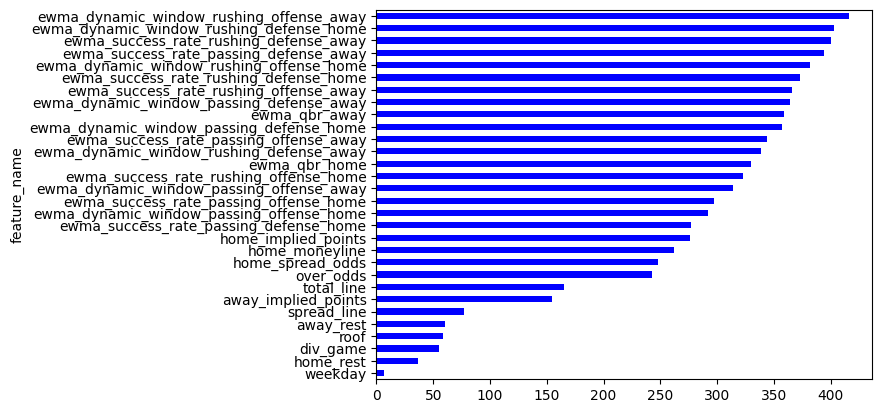

In [724]:
from matplotlib import pyplot as plt
feature_importances = home_model.named_steps['lgbmregressor'].feature_importances_
import_df = pd.DataFrame(zip(features,feature_importances),columns=['feature_name','feature_importance']).sort_values(by='feature_importance',ascending=True)

feature_imp = pd.Series(import_df['feature_importance'].values,index=import_df['feature_name'])
feature_imp.plot(kind='barh',color='blue')
plt.show()

In [725]:
results = train_df.loc[X_test.index]
results['away_score_pred'] = away_scores
results['home_score_pred'] = home_scores
results['true_spread'] = true_spreads
results['spread_pred']=predicted_spreads
results['true_total'] = y_test.iloc[:,0] + y_test.iloc[:,1]
results['total_pred'] = away_scores + home_scores




results['spread_play'] = results.apply(lambda row: row['away_team'] if row['spread_pred'] < row['spread_line'] else row['home_team'], axis=1)
results['correct_spread_play'] = results.apply(lambda row: np.nan if pd.isnull(row['true_spread']) else (row['away_team'] if row['true_spread'] < row['spread_line'] else row['home_team']), axis=1)
results['spread_win'] = results.apply(lambda row: np.nan if pd.isnull(row['correct_spread_play']) else (1 if row['spread_play'] == row['correct_spread_play'] else 0), axis=1)

results['total_play'] = results.apply(lambda row: 'under' if row['total_pred'] < row['total_line'] else ('over' if row['total_pred'] > row['total_line'] else None), axis=1)
results['correct_total_play'] = results.apply(lambda row: np.nan if pd.isnull(row['true_total']) else ('under' if row['true_total'] < row['total_line'] else ('over' if row['true_total'] > row['total_line'] else 'push')), axis=1)
results['total_win'] = results.apply(lambda row: np.nan if pd.isnull(row['correct_total_play']) else (1 if row['correct_total_play'] == row['total_play'] else 0), axis=1)

results [['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score', 'away_score_pred', 'away_score', 
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'correct_spread_play', 'spread_win',
          'total_pred', 'total_line', 'true_total', 'total_play', 'correct_total_play', 'total_win']]

,season,week,home_team,away_team,home_score_pred,home_score,away_score_pred,away_score,spread_pred,spread_line,true_spread,spread_play,correct_spread_play,spread_win,total_pred,total_line,true_total,total_play,correct_total_play,total_win
1304,2014,16,LA,NYG,26.439172,27.0,14.643468,37.0,11.795704,7.0,-10.0,LA,NYG,0,41.082640,43.5,64.0,under,over,0
2630,2019,16,SF,LA,26.885171,34.0,19.450054,31.0,7.435117,7.0,3.0,SF,LA,0,46.335224,45.5,65.0,over,over,1
2371,2018,16,PHI,HOU,22.992468,32.0,23.680577,30.0,-0.688109,1.0,2.0,HOU,PHI,0,46.673045,47.0,62.0,under,over,0
314,2011,3,IND,PIT,19.406647,20.0,29.295339,23.0,-9.888693,-10.5,-3.0,IND,IND,1,48.701986,39.5,43.0,over,over,1
1139,2014,5,TEN,CLE,15.976701,28.0,23.787989,29.0,-7.811288,-1.0,-1.0,CLE,TEN,0,39.764691,44.5,57.0,under,over,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2010,9,HOU,LAC,25.945756,23.0,26.455700,29.0,-0.509943,-3.0,-6.0,HOU,LAC,0,52.401456,50.0,52.0,over,over,1
3080,2021,10,NYJ,BUF,9.720039,17.0,24.125362,45.0,-14.405323,-13.0,-28.0,BUF,BUF,1,33.845401,47.0,62.0,under,over,0
3659,2023,11,BAL,CIN,26.131180,34.0,17.301773,20.0,8.829408,4.0,14.0,BAL,BAL,1,43.432953,46.5,54.0,under,over,0
2931,2020,18,NO,CHI,30.102167,21.0,26.597512,9.0,3.504655,11.0,12.0,CHI,NO,0,56.699679,48.0,30.0,over,under,0


In [726]:
print(f"Total win percentage: {100.0*results['total_win'].mean()}\nSpread win percentage: {100*results['spread_win'].mean()}")

Total win percentage: 49.735449735449734
Spread win percentage: 48.544973544973544


## Train classification models

In [727]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


results['spread_diff'] = abs(results['spread_line'] - results['spread_pred'])
results['total_diff'] = abs(results['total_line'] - results['total_pred'])


spread_class_features =  ewma_features+other_features+['spread_diff']
total_class_features = ewma_features+other_features+['total_diff']



#['spread_diff', 'total_diff', 'home_score_pred', 'away_score_pred', 'home_moneyline', 'home_spread_odds', 'spread_line', 'total_line']

# Prepare the dataset
spread_X = results[spread_class_features]
total_X = results[total_class_features]

spread_y = results['spread_win']
total_y = results['total_win']

param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }

# Create and train the classifiers LGBMClassifier RandomForestClassifier
spread_clf = GridSearchCV(LGBMClassifier(random_state = 2,  verbose = -1), param_grid, cv=5)
total_clf = GridSearchCV(LGBMClassifier(random_state = 2, verbose = -1), param_grid, cv=5)
spread_clf.fit(spread_X, spread_y)
total_clf.fit(total_X, total_y)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=2, verbose=-1),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [728]:
from scipy.stats import pointbiserialr

corr, _ = pointbiserialr(results["spread_win"], results["home_moneyline"])
print('Pearsons correlation: %.3f' % corr)

corr, _ = pointbiserialr(results["spread_win"], results["spread_diff"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.005
Pearsons correlation: 0.020


# This week's plays

In [729]:
print(train_df.shape)

X = train_df.loc[:, features]
y = train_df.loc[:, targets]

y_home = y.iloc[:,0]
y_away = y.iloc[:,1]

away_model =  away_model.fit(X, y_away)
home_model =  home_model.fit(X, y_home)

(3842, 196)


In [730]:
this_week = df[(df['season'] == current_year) & (df['week'] == current_week)]
#this_week = this_week[~this_week['home_score'].notnull()]

this_week_away_scores = away_model.predict(this_week[features])
this_week_home_scores = home_model.predict(this_week[features])

this_week_predicted_spreads = this_week_away_scores - this_week_home_scores

In [802]:
plays = this_week.copy()
plays['away_score_pred'] = this_week_away_scores
plays['home_score_pred'] = this_week_home_scores
plays['spread_pred']= this_week_predicted_spreads
plays['total_pred'] = this_week_away_scores + this_week_home_scores

plays['spread_line'] = plays['spread_line'] * -1


plays['spread_play'] = plays.apply(lambda row: row['home_team'] if row['spread_pred'] < row['spread_line'] else row['away_team'], axis=1)

# Assuming 'df' is your DataFrame

plays['total_play'] = plays.apply(lambda row: 'under' if row['total_pred'] < row['total_line'] else ('over' if row['total_pred'] > row['total_line'] else None), axis=1)


In [803]:

from sklearn.preprocessing import LabelEncoder

def win_probability(df, classifier, features):
    # Transform categorical features into numerical values

    df['spread_diff'] = abs(df['spread_line'] -df['spread_pred'])
    df['total_diff'] = abs(df['total_line'] -df['total_pred'])

    # Now that the model is trained, we can use it to predict the probabilities for the plays in plays_df
    win_probs = classifier.predict_proba(df[features])[:, 1] * 100

    return win_probs

plays['spread_win_prob'] = win_probability(plays, classifier = spread_clf, features = spread_class_features)
plays['total_win_prob'] = win_probability(plays, classifier = total_clf, features = total_class_features)


In [807]:
def best_plays(df, n):
    spread_plays = df.nlargest(n, 'spread_win_prob')
    total_plays = df.nlargest(n, 'total_win_prob')

    df['spread_lock'] = 0
    df['total_lock'] = 0

    print("Spread plays:")
    for _, row in spread_plays.iterrows():
        if abs(row['spread_pred'] - row['spread_line']) >= 0.5 and row['total_win_prob']>0.55:
            if row['spread_play'] == row['away_team']:
                mult = -1
            else: 
                mult = 1
            
            pref = '+' if row['spread_line'] * mult > 0 else ''
            pref2 = '+' if row['spread_pred'] * mult > 0 else ''

            df.loc[_,'spread_lock'] = 1

            print(f"{row['home_team']}/{row['away_team']}: {row['spread_play']} {pref}{row['spread_line']*mult} (model {row['spread_play']} {pref2}{(row['spread_pred']*mult):.2f}, {row['spread_win_prob']:.2f}% win probability)")

    print("\nTotal plays:")
    for _, row in total_plays.iterrows():
        if abs(row['total_pred'] - row['total_line']) >= 0.5 and row['total_win_prob']>55.0:
            df.loc[_,'total_lock'] = 1

            print(f"{row['home_team']}/{row['away_team']}: {row['total_play']} {row['total_line']} (model {row['total_pred']:.2f}, {row['total_win_prob']:.2f}% win probability)")

    return df


# Example usage:
plays = best_plays(plays, 5)
plays[['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'away_score_pred', 
          'spread_pred', 'spread_line',  'spread_play', 'spread_win_prob', 'spread_lock', 'total_pred', 'total_line', 'total_play', 'total_win_prob', 'total_lock']]

Spread plays:
CHI/CAR: CAR +4.0 (model CAR +0.86, 64.98% win probability)
SF/ARI: ARI +7.0 (model ARI +4.89, 57.42% win probability)
PIT/DAL: DAL +2.5 (model DAL -0.01, 55.76% win probability)
ATL/TB: TB +2.5 (model TB -1.38, 55.33% win probability)

Total plays:
DEN/LV: over 35.5 (model 36.76, 72.50% win probability)
KC/NO: under 42.5 (model 41.33, 70.26% win probability)
LA/GB: over 48.5 (model 52.90, 63.93% win probability)


,season,week,home_team,away_team,home_score_pred,away_score_pred,spread_pred,spread_line,spread_play,spread_win_prob,spread_lock,total_pred,total_line,total_play,total_win_prob,total_lock
3858,2024,5,ATL,TB,23.764919,25.146928,1.382009,-2.5,TB,55.328296,1,48.911847,44.0,over,19.702790,0
3859,2024,5,MIN,NYJ,33.885069,20.341594,-13.543474,-2.0,MIN,46.732291,0,54.226663,40.0,over,17.063386,0
3860,2024,5,CHI,CAR,21.353341,20.498003,-0.855338,-4.0,CAR,64.979284,1,41.851345,41.0,over,46.471508,0
3861,2024,5,CIN,BAL,26.051550,21.816143,-4.235407,2.5,CIN,33.653720,0,47.867693,49.0,under,26.286370,0
3862,2024,5,HOU,BUF,23.396470,22.442287,-0.954182,-1.0,BUF,68.842879,0,45.838757,47.5,under,24.759262,0
3863,2024,5,JAX,IND,23.258295,21.905373,-1.352922,-3.0,IND,28.656398,0,45.163667,46.0,under,34.460923,0
3864,2024,5,NE,MIA,16.382184,18.984836,2.602651,-1.0,MIA,42.627191,0,35.367020,36.5,under,49.327682,0
3865,2024,5,WAS,CLE,19.797283,23.673846,3.876563,-3.5,CLE,50.237841,0,43.471129,43.5,under,44.555217,0
3866,2024,5,DEN,LV,19.386236,17.372511,-2.013725,-2.5,LV,48.430093,0,36.758747,35.5,over,72.497397,1
3867,2024,5,SF,ARI,27.056208,22.164119,-4.892090,-7.0,ARI,57.419208,1,49.220327,50.0,under,31.275092,0


In [808]:
with open(f'previous_models/away_model_{current_year_week}.pkl', 'wb') as f:
    pickle.dump(away_model, f)

with open(f'previous_models/home_model_{current_year_week}.pkl', 'wb') as f:
    pickle.dump(away_model, f)

In [810]:
dynamodb = boto3.resource('dynamodb', region_name='us-east-1')  

def convert_to_decimal(value):
    if isinstance(value, float):
        return Decimal(str(value))
    return value

def delete_dynamo_enteries(table, keys):

    partition_key=keys['PartitionKey']
    sort_key=keys['SortKey']

    response = table.scan()
    items = response['Items']
    with table.batch_writer() as batch:
        for item in items:
            batch.delete_item(Key={
                partition_key: item[partition_key],
                sort_key: item[sort_key]
            })

            
def dynamo_add_column(table, df, column_name, new_write_function, delete_function, keys):

    saved_table = pd.DataFrame(table.scan().get('Items'))
    
    if len(saved_table)>0:
        print(f"{len(saved_table)} rows saved. DF has {saved_table.shape[1]} columns")
    
    delete_function(table, keys)
    print("Table deleted")

    saved_table = saved_table.merge(df[['game_id', column_name]], on='game_id', how='left')
    print(f"Now {len(saved_table)} rows and {saved_table.shape[1]} columns")

    new_write_function(saved_table, table)
    updated_dynamo_table = pd.DataFrame(table.scan().get('Items'))
    print(f"Write done, updated dynamo table has {len(updated_dynamo_table)} rows and {updated_dynamo_table.shape[1]} columns")
#dynamo_add_column(historical_results_table, df, 'spread_lock',write_dynamo_results, delete_dynamo_enteries, {'PartitionKey': 'year_week', 'SortKey': 'game_id'})

def query_results(table, key_object):
    key_name = key_object[0]
    key_val = key_object[1]

    response = table.query(
        KeyConditionExpression=Key(key_name).eq(key_val)
    )
    return response.get('Items')

def write_dynamo_picks(df, picks_table):
    for index, row in df.iterrows():
        picks_table.put_item(
            Item={
                'year_week': row['year_week'],
                'game_id': str(row['game_id']),
                'season': row['season'],
                'week': str(row['week']),  
                'home_team': row['home_team'],
                'away_team': row['away_team'],
                'home_score_pred': convert_to_decimal(row['home_score_pred']),
                'away_score_pred': convert_to_decimal(row['away_score_pred']),
                'spread_pred': convert_to_decimal(row['spread_pred']),
                'spread_line': convert_to_decimal(row['spread_line']),
                'spread_play': row['spread_play'],
                'spread_win_prob': convert_to_decimal(row['spread_win_prob']),
                'spread_lock': row['spread_lock'],
                'total_pred': convert_to_decimal(row['total_pred']),
                'total_line': convert_to_decimal(row['total_line']),
                'total_play': row['total_play'],
                'total_win_prob': convert_to_decimal(row['total_win_prob']),
                'total_lock': row['total_lock'],
                'date_time': row['date_time']
            }
        )

def write_dynamo_results(df, historical_results_table):
    for index, row in df.iterrows():
        historical_results_table.put_item(
            Item={
                'year_week': row['year_week'],
                'game_id': str(row['game_id']),
                'season': row['season'],
                'week': str(row['week']),
                'home_team': row['home_team'],
                'away_team': row['away_team'],
                'home_score_pred': convert_to_decimal(row['home_score_pred']),
                'home_score': convert_to_decimal(row['home_score']),
                'spread_pred': convert_to_decimal(row['spread_pred']),
                'spread_line': convert_to_decimal(row['spread_line']),
                'true_spread': convert_to_decimal(row['true_spread']),
                'spread_play': row['spread_play'],
                'spread_win_prob': convert_to_decimal(row['spread_win_prob']),
                'spread_lock': row['spread_lock'],
                'correct_spread_play': row['correct_spread_play'],
                'spread_win': row['spread_win'],
                'total_pred': convert_to_decimal(row['total_pred']),
                'total_line': convert_to_decimal(row['total_line']),
                'true_total': convert_to_decimal(row['true_total']),
                'total_play': row['total_play'],
                'total_win_prob': convert_to_decimal(row['total_win_prob']),
                'correct_total_play': row['correct_total_play'],
                'total_win': row['total_win'],
                'total_lock': row['total_lock'],
                'date_time': row['date_time']
            }
        )

## Write picks to DB

In [811]:
picks_table = dynamodb.Table('nfl_expected_points_picks')
historical_picks_table = dynamodb.Table('nfl_expected_points_historical_picks')


write_dynamo_picks(plays, historical_picks_table)

if len(plays)>5:
    delete_dynamo_enteries(picks_table, {'PartitionKey': 'year_week', 'SortKey': 'game_id'})
    write_dynamo_picks(plays, picks_table)

## Update model record

In [774]:
historical_results_table = dynamodb.Table('nfl_expected_points_results')

historical_picks = historical_picks_table.scan().get('Items',[])
historical_results = historical_results_table.scan().get('Items',[])

picks_game_ids = {item['game_id'] for item in historical_picks}
results_game_ids = {item['game_id'] for item in historical_results}

no_results = list(picks_game_ids - results_game_ids)
print(f"Games not in picks that are in results (should be 0): {len(results_game_ids - picks_game_ids)}")
print(f"{len(no_results)} picks need to be updated")

Games not in picks that are in results (should be 0): 0
13 picks need to be updated


In [775]:
picks_to_update = pd.DataFrame([item for item in historical_picks if item['game_id'] in no_results])

scores = {
    row['game_id']: {'home_score': row['home_score'], 'away_score': row['away_score']}
    for _, row in df[['game_id', 'home_score', 'away_score']].iterrows()
    if pd.notna(row['home_score']) and pd.notna(row['away_score'])
}

picks_to_update = picks_to_update[picks_to_update['game_id'].isin(scores.keys())].copy()

picks_to_update['home_score'] = picks_to_update['game_id'].apply(lambda x: scores[x]['home_score'])
picks_to_update['away_score'] = picks_to_update['game_id'].apply(lambda x: scores[x]['away_score'])

picks_to_update['true_spread'] = picks_to_update['away_score'] - picks_to_update['home_score']
picks_to_update['correct_spread_play'] = picks_to_update.apply(lambda row: row['home_team'] if row['true_spread'] < row['spread_line'] else row['away_team'], axis=1)
picks_to_update['spread_win'] = picks_to_update.apply(lambda row: 1 if row['spread_play'] == row['correct_spread_play'] else 0, axis=1)

picks_to_update['true_total'] = picks_to_update['away_score'] + picks_to_update['home_score']
picks_to_update['correct_total_play'] = picks_to_update.apply(lambda row: 'under' if row['true_total'] < row['total_line'] else ('over' if row['true_total'] > row['total_line'] else None), axis=1)
picks_to_update['total_win'] = picks_to_update.apply(lambda row: 1 if row['correct_total_play'] == row['total_play'] else 0, axis=1)


print(f"Updating {len(picks_to_update)} picks")

Updating 0 picks


In [792]:
def get_result_stats(df, Verbose = False):
    
    total_spread_wins = df['spread_win'].sum()
    total_total_wins = df['total_win'].sum()
    total_games = len(df)

    total_spread_ratio = 100 * total_spread_wins / total_games
    total_total_ratio = 100 * total_total_wins / total_games

    total_spread_lock_wins = df[df['spread_lock']==1]['spread_win'].sum()
    total_total_lock_wins = df[df['total_lock']==1]['total_win'].sum()
    total_spread_lock_games = len(df[df['spread_lock']==1])
    total_total_lock_games = len(df[df['total_lock']==1])


    total_spread_lock_ratio = 100* total_spread_lock_wins / total_spread_lock_games 
    total_total_lock_ratio = 100 * total_total_lock_wins / total_total_lock_games

    if Verbose:

        print(f"Spread Win percentage: {total_spread_ratio:.2f}%")
        print(f"Total win percentage: {total_total_ratio:.2f}%\n")

        if total_spread_lock_games != 0:
            total_spread_lock_ratio = 100 * total_spread_lock_wins / total_spread_lock_games
            print(f"Spread lock win percentage: {total_spread_lock_ratio:.2f}%")
        else:
            print("No spread locks")

        if total_total_lock_games != 0:
            total_total_lock_ratio = 100 * total_total_lock_wins / total_total_lock_games
            print(f"Total lock win percentage: {total_total_lock_ratio:.2f}%")
        else:
            print("No total locks")

    data = {
        "pedicted_games": total_games,

        "spread_wins": total_spread_wins,
        "spread_win_pct": total_spread_ratio,
        "spread_lock_predictions": total_spread_lock_games,
        "spread_lock_wins": total_spread_lock_wins,
        "spread_lock_win_pct": total_spread_lock_ratio,

        "total_wins": total_total_wins,
        "total_win_pct": total_total_ratio,
        "total_lock_predictions": total_spread_lock_games,
        "total_lock_wins": total_spread_lock_wins,
        "total_lock_win_pct": total_spread_lock_ratio,
    }

    return data

check = get_result_stats(picks_to_update, Verbose = True)

Spread Win percentage: 50.77%
Total win percentage: 53.85%

Spread lock win percentage: 52.38%
Total lock win percentage: 55.00%


In [770]:
picks_to_update

,spread_pred,total_win_prob,season,total_line,away_team,total_play,date_time,home_score_pred,total_pred,week,...,year_week,game_id,home_score,away_score,true_spread,correct_spread_play,spread_win,true_total,correct_total_play,total_win
0,0.9468280261210396,17.11812872658573,2024,46.5,BUF,over,2024-09-29-20:20,23.550076768372485,48.04698156286601,4,...,2024_4,2024_04_BUF_BAL,35.0,10.0,-25.0,BAL,0,45.0,under,0
1,6.5564971951617785,24.660891812382626,2024,47,CIN,over,2024-09-29-13:00,23.333920374834978,53.22433794483173,4,...,2024_4,2024_04_CIN_CAR,24.0,34.0,10.0,CIN,1,58.0,over,1
2,-1.638884546971621,44.04684528001697,2024,36.5,CLE,over,2024-09-29-16:25,19.979518342439057,38.32015213790649,4,...,2024_4,2024_04_CLE_LV,20.0,16.0,-4.0,LV,1,36.0,under,0
3,8.693795902336696,33.895153812407926,2024,45,DAL,under,2024-09-26-20:15,16.703344444767207,42.10048479187111,4,...,2024_4,2024_04_DAL_NYG,15.0,20.0,5.0,NYG,0,35.0,under,1
4,-6.270982053229094,55.62755298025518,2024,39.5,DEN,over,2024-09-29-13:00,23.94112044710035,41.6112588409716,4,...,2024_4,2024_04_DEN_NYJ,9.0,10.0,1.0,DEN,1,19.0,under,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-4.17048912025232,31.53469087891183,2024,40.5,NE,over,2024-09-08-13:00,26.21195988690472,48.25343065355712,1,...,2024_1,2024_01_NE_CIN,10.0,16.0,6.0,NE,1,26.0,under,0
74,-12.926138860775406,21.514136457666766,2024,43,NYJ,over,2024-09-09-20:15,29.651875137348302,46.3776114139212,1,...,2024_1,2024_01_NYJ_SF,32.0,19.0,-13.0,SF,1,51.0,over,1
75,-4.4100418850492,23.23074499393112,2024,43,PIT,over,2024-09-08-13:00,25.683799089639137,46.95755629422908,1,...,2024_1,2024_01_PIT_ATL,10.0,18.0,8.0,PIT,0,28.0,under,0
76,-6.07628265045204,50.930210713122236,2024,43,TEN,over,2024-09-08-13:00,25.619691424791398,45.16310019913075,1,...,2024_1,2024_01_TEN_CHI,24.0,17.0,-7.0,CHI,1,41.0,under,0


In [771]:
write_dynamo_results(picks_to_update, historical_results_table)

# Model record

In [793]:
test = pd.DataFrame(historical_results_table.scan()['Items'])

In [795]:
test

,true_total,season,total_win_prob,total_line,total_play,home_score,total_lock,true_spread,spread_win_prob,home_team,...,date_time,home_score_pred,total_pred,week,spread_play,spread_line,spread_win,correct_spread_play,spread_lock,year_week
0,45,2024,17.11812872658573,46.5,over,35,0,-25,45.87065441784316,BAL,...,2024-09-29-20:20,23.550076768372485,48.04698156286601,4,BUF,-2.5,0,BAL,0,2024_4
1,58,2024,24.660891812382626,47,over,24,0,10,51.8419317219918,CAR,...,2024-09-29-13:00,23.333920374834978,53.22433794483173,4,CIN,4.5,1,CIN,1,2024_4
2,36,2024,44.04684528001697,36.5,over,20,0,-4,46.181667296151765,LV,...,2024-09-29-16:25,19.979518342439057,38.32015213790649,4,LV,2.5,1,LV,0,2024_4
3,35,2024,33.895153812407926,45,under,15,0,5,61.60775853034269,NYG,...,2024-09-26-20:15,16.703344444767207,42.10048479187111,4,DAL,5.5,0,NYG,1,2024_4
4,19,2024,55.62755298025518,39.5,over,9,1,1,75.31714040057567,NYJ,...,2024-09-29-13:00,23.94112044710035,41.6112588409716,4,DEN,-7.5,1,DEN,1,2024_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,26,2024,31.53469087891183,40.5,over,10,0,6,55.96227256422094,CIN,...,2024-09-08-13:00,26.21195988690472,48.25343065355712,1,NE,-8,1,NE,1,2024_1
61,51,2024,21.514136457666766,43,over,32,0,-13,58.53457952500997,SF,...,2024-09-09-20:15,29.651875137348302,46.3776114139212,1,SF,-3.5,1,SF,1,2024_1
62,28,2024,23.23074499393112,43,over,10,0,8,28.613435262728864,ATL,...,2024-09-08-13:00,25.683799089639137,46.95755629422908,1,ATL,-4,0,PIT,0,2024_1
63,41,2024,50.930210713122236,43,over,24,0,-7,35.52730051199372,CHI,...,2024-09-08-13:00,25.619691424791398,45.16310019913075,1,CHI,-4,1,CHI,0,2024_1


In [798]:
test[['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score',
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob' , 'spread_lock', 'correct_spread_play', 'spread_win',
          'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 'total_lock', 'correct_total_play', 'total_win', 'year_week','game_id','date_time']].columns

Index(['season', 'week', 'home_team', 'away_team', 'home_score_pred',
       'home_score', 'spread_pred', 'spread_line', 'true_spread',
       'spread_play', 'spread_win_prob', 'spread_lock', 'correct_spread_play',
       'spread_win', 'total_pred', 'total_line', 'true_total', 'total_play',
       'total_win_prob', 'total_lock', 'correct_total_play', 'total_win',
       'year_week', 'game_id', 'date_time'],
      dtype='object')

In [410]:
def season_stats(df, current_week, year, away_model, home_model, spread_clf, total_clf):
    season_results = {}
    for i in range(1,current_week+1):
        train_df = df[((df['season'] == year) & (df['week'] < i)) | (df['season'] < year)]

        X_train = train_df.loc[:, features]
        y_train = train_df.loc[:, targets]
        y_home_train = y_train.iloc[:,0]
        y_away_train = y_train.iloc[:,1]

        away_model_temp =  away_model.fit(X_train, y_away_train)
        home_model_temp =  home_model.fit(X_train, y_home_train)

        X = train_df.loc[:, features]
        y = train_df.loc[:, targets]
        y_home = y.iloc[:,0]
        y_away = y.iloc[:,1]

        test_df = df[(df['season'] == year) & (df['week'] == i)]
        X = test_df.loc[:, features]
        y = test_df.loc[:, targets]
        y_home = y.iloc[:,0]
        y_away = y.iloc[:,1]

        temp_away_scores = away_model_temp.predict(X[features])
        temp_home_scores = home_model_temp.predict(X[features])
        
        temp_predicted_spreads = temp_away_scores - temp_home_scores
        temp_true_spreads = y_away - y_home

        results = test_df.copy()
        results['away_score_pred'] = temp_away_scores
        results['home_score_pred'] = temp_home_scores
        results['true_spread'] = temp_true_spreads
        results['spread_pred']=temp_predicted_spreads
        results['true_total'] = y_away + y_home
        results['total_pred'] = temp_away_scores + temp_home_scores



        results['spread_play'] = results.apply(lambda row: row['away_team'] if row['spread_pred'] < row['spread_line'] else row['home_team'], axis=1)
        results['correct_spread_play'] = results.apply(lambda row: np.nan if pd.isnull(row['true_spread']) else (row['away_team'] if row['true_spread'] < row['spread_line'] else row['home_team']), axis=1)
        results['spread_win'] = results.apply(lambda row: np.nan if pd.isnull(row['correct_spread_play']) else (1 if row['spread_play'] == row['correct_spread_play'] else 0), axis=1)

        results['total_play'] = results.apply(lambda row: 'under' if row['total_pred'] < row['total_line'] else ('over' if row['total_pred'] > row['total_line'] else None), axis=1)
        results['correct_total_play'] = results.apply(lambda row: np.nan if pd.isnull(row['true_total']) else ('under' if row['true_total'] < row['total_line'] else ('over' if row['true_total'] > row['total_line'] else None)), axis=1)
        results['total_win'] = results.apply(lambda row: np.nan if pd.isnull(row['correct_total_play']) else (1 if row['correct_total_play'] == row['total_play'] else 0), axis=1)

        results['spread_pct_diff'] = abs(results['spread_pred'] - results['spread_line']) / results['spread_line'] * 100
        results['total_pct_diff'] = abs(results['total_pred'] - results['total_line']) / results['total_line'] * 100


        results['spread_win_prob'] = win_probability(results, classifier = spread_clf, features = spread_class_features)
        results['total_win_prob'] = win_probability(results, classifier = total_clf, features = total_class_features)
        
        spread_locks = results.nlargest(5, 'spread_win_prob')
        total_locks = results.nlargest(5, 'total_win_prob')

        # spread_locks = results.nlargest(3, 'spread_pct_diff')
        # total_locks = results.nlargest(3, 'total_pct_diff')

        

        season_results[i] = {'spread_wins': results['spread_win'].sum(), 
                             'total_wins': results['total_win'].sum(), 
                             'games': results['spread_win'].count(),
                             'spread_perc': 100*results['spread_win'].sum()/results['spread_win'].count()*1.0,
                             'total_perc': 100*results['total_win'].sum()/results['total_win'].count()*1.0,
                             'spread_lock_wins': spread_locks['spread_win'].sum(), 
                             'total_lock_wins': total_locks['total_win'].sum(), 
                             'spread_lock_perc': 100*spread_locks['spread_win'].sum()/spread_locks['spread_win'].count(),
                             'total_lock_perc': 100*total_locks['total_win'].sum()/total_locks['total_win'].count(),
                             'spread_lock_games': spread_locks['spread_win'].count(),
                             'total_lock_games': total_locks['total_win'].count(),
                             'df': results,
                             'spread_locks_df': spread_locks,
                             'total_locks_df': total_locks}
        
    return season_results

In [413]:
season_results = season_stats(df, current_week = 4, year = 2024, away_model = away_model, home_model = home_model, spread_clf = spread_clf, total_clf = total_clf)

total_spread_wins = sum(val['spread_wins'] for val in season_results.values())
total_total_wins = sum(val['total_wins'] for val in season_results.values())
total_games = sum(val['games'] for val in season_results.values())

total_spread_ratio = 100 * total_spread_wins / total_games
total_total_ratio = 100 * total_total_wins / total_games

total_spread_lock_wins = sum(val['spread_lock_wins'] for val in season_results.values())
total_total_lock_wins = sum(val['total_lock_wins'] for val in season_results.values())
total_spread_lock_games = sum(val['spread_lock_games'] for val in season_results.values())
total_total_lock_games = sum(val['total_lock_games'] for val in season_results.values())


total_spread_lock_ratio = 100* total_spread_lock_wins / total_spread_lock_games 
total_total_lock_ratio = 100 * total_total_lock_wins / total_total_lock_games

print(f"Season spread win percentage: {total_spread_ratio:.2f}%")
print(f"Season total win percentage: {total_total_ratio:.2f}%\n")
print(f"Season spread lock win percentage: {total_spread_lock_ratio:.2f}%")
print(f"Season total lock win percentage: {total_total_lock_ratio:.2f}%")

Season spread win percentage: 50.00%
Season total win percentage: 53.12%

Season spread lock win percentage: 55.00%
Season total lock win percentage: 55.00%


In [244]:
df = season_results[1]['df']
df['year_week'] = df['season'].astype(str) + '_' + df['week'].astype(str)
df[['year_week','game_id','season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score',
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob' , 'correct_spread_play', 'spread_win',
          'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 'correct_total_play', 'total_win']]

,year_week,game_id,season,week,home_team,away_team,home_score_pred,home_score,spread_pred,spread_line,...,spread_win_prob,correct_spread_play,spread_win,total_pred,total_line,true_total,total_play,total_win_prob,correct_total_play,total_win
3794,2024_1,2024_01_BAL_KC,2024,1,KC,BAL,23.763583,27.0,3.707648,3.0,...,51.059530,KC,1,43.819519,46.0,47.0,under,30.045994,over,0
3795,2024_1,2024_01_GB_PHI,2024,1,PHI,GB,28.761786,34.0,12.419681,2.0,...,61.139434,PHI,1,45.103892,49.5,63.0,under,41.715101,over,0
3796,2024_1,2024_01_PIT_ATL,2024,1,ATL,PIT,25.683799,10.0,4.410042,4.0,...,51.523038,PIT,0,46.957556,43.0,28.0,over,39.424945,under,0
3797,2024_1,2024_01_ARI_BUF,2024,1,BUF,ARI,30.632249,34.0,8.241855,6.5,...,48.009520,ARI,0,53.022643,46.0,62.0,over,84.491555,over,1
3798,2024_1,2024_01_TEN_CHI,2024,1,CHI,TEN,25.619691,24.0,6.076283,4.0,...,62.408519,CHI,1,45.163100,43.0,41.0,over,51.396845,under,0
3799,2024_1,2024_01_NE_CIN,2024,1,CIN,NE,26.211960,10.0,4.170489,8.0,...,49.948036,NE,1,48.253431,40.5,26.0,over,36.348195,under,0
3800,2024_1,2024_01_HOU_IND,2024,1,IND,HOU,19.629374,27.0,-5.588458,-3.0,...,52.817428,IND,0,44.847206,49.0,56.0,under,47.683392,over,0
3801,2024_1,2024_01_JAX_MIA,2024,1,MIA,JAX,26.188110,20.0,2.326464,3.5,...,46.579743,JAX,1,50.049757,49.5,37.0,over,50.211146,under,0
3802,2024_1,2024_01_CAR_NO,2024,1,NO,CAR,24.228697,47.0,1.383595,3.5,...,53.981351,NO,0,47.073799,41.5,57.0,over,20.749603,over,1
3803,2024_1,2024_01_MIN_NYG,2024,1,NYG,MIN,21.504300,6.0,0.524683,-1.0,...,66.192038,MIN,0,42.483918,42.5,34.0,under,13.999852,under,1


In [245]:
check_week = 2
print(f"Week {check_week} spread win percentage: {season_results[check_week]['spread_perc']:.2f}%")
print(f"Week {check_week} total win percentage: {season_results[check_week]['total_perc']:.2f}%\n")
print(f"Week {check_week} spread lock win percentage: {season_results[check_week]['spread_lock_perc']:.2f}%")
print(f"Week {check_week} total lock win percentage: {season_results[check_week]['total_lock_perc']:.2f}%")

Week 2 spread win percentage: 56.25%
Week 2 total win percentage: 68.75%

Week 2 spread lock win percentage: 60.00%
Week 2 total lock win percentage: 100.00%


In [246]:
season_results[4]['df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score',
          'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob' , 'correct_spread_play', 'spread_win',
          'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 'correct_total_play', 'total_win']]

,season,week,home_team,away_team,home_score_pred,home_score,spread_pred,spread_line,true_spread,spread_play,spread_win_prob,correct_spread_play,spread_win,total_pred,total_line,true_total,total_play,total_win_prob,correct_total_play,total_win
3842,2024,4,NYG,DAL,16.703344,15.0,-8.693796,-5.5,-5.0,DAL,45.600235,NYG,0,42.100485,45.0,35.0,under,58.868575,under,1
3843,2024,4,ATL,NO,22.848740,26.0,-2.535837,2.5,2.0,NO,54.416106,NO,1,48.233317,41.5,50.0,over,70.762942,over,1
3844,2024,4,CAR,CIN,23.333920,24.0,-6.556497,-4.5,-10.0,CIN,57.167352,CIN,1,53.224338,47.0,58.0,over,82.164559,over,1
3845,2024,4,CHI,LA,22.029294,24.0,1.401981,3.0,6.0,LA,54.019234,CHI,0,42.656608,40.0,42.0,over,70.451877,over,1
3846,2024,4,GB,MIN,22.140346,29.0,3.502799,2.5,-2.0,GB,47.330288,MIN,0,40.777893,44.0,60.0,under,51.475143,over,0
3847,2024,4,HOU,JAX,32.486968,24.0,14.257919,5.5,4.0,HOU,70.599947,JAX,0,50.716016,44.5,44.0,over,65.536666,under,0
3848,2024,4,IND,PIT,20.448996,27.0,-0.664179,-2.5,3.0,IND,39.754149,IND,1,41.562171,40.0,51.0,over,40.380344,over,1
3849,2024,4,NYJ,DEN,23.941120,9.0,6.270982,7.5,-1.0,DEN,55.636431,DEN,1,41.611259,39.5,19.0,over,74.281007,under,0
3850,2024,4,TB,PHI,19.532987,33.0,-2.563405,-1.0,17.0,PHI,63.511029,TB,0,41.629379,42.0,49.0,under,41.760528,over,0
3851,2024,4,ARI,WAS,29.463173,14.0,6.123964,3.5,-28.0,ARI,52.395994,WAS,0,52.802383,49.0,56.0,over,51.963119,over,1


In [247]:
season_results[check_week]['spread_locks_df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score', 'away_score_pred', 'away_score', 
           'spread_pred', 'spread_line', 'true_spread', 'spread_play', 'spread_win_prob', 'correct_spread_play', 'spread_win']]

,season,week,home_team,away_team,home_score_pred,home_score,away_score_pred,away_score,spread_pred,spread_line,true_spread,spread_play,spread_win_prob,correct_spread_play,spread_win
3823,2024,2,KC,CIN,30.525110,26.0,20.950213,25.0,9.574897,6.5,1.0,KC,75.578087,CIN,0
3818,2024,2,NE,SEA,23.747448,20.0,18.202450,23.0,5.544999,-3.5,-3.0,NE,71.541541,NE,1
3813,2024,2,DAL,NO,26.250288,19.0,21.051116,44.0,5.199172,6.5,-25.0,NO,70.140165,NO,1
3824,2024,2,HOU,CHI,22.157520,19.0,18.807480,13.0,3.350039,6.0,6.0,CHI,65.364079,HOU,0
3822,2024,2,DEN,PIT,17.949088,6.0,23.725234,13.0,-5.776146,-3.0,-7.0,PIT,63.329542,PIT,1


In [248]:
season_results[check_week]['total_locks_df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'home_score', 'away_score_pred', 'away_score', 
          'total_pred', 'total_line', 'true_total', 'total_play', 'total_win_prob', 'correct_total_play', 'total_win', 'spread_play']]

,season,week,home_team,away_team,home_score_pred,home_score,away_score_pred,away_score,total_pred,total_line,true_total,total_play,total_win_prob,correct_total_play,total_win,spread_play
3812,2024,2,CAR,LAC,15.252023,3.0,18.798629,26.0,34.050651,39.0,29.0,under,85.812429,under,1,CAR
3818,2024,2,NE,SEA,23.747448,20.0,18.202450,23.0,41.949898,39.0,43.0,over,80.852127,over,1,NE
3815,2024,2,GB,IND,18.880204,16.0,20.379963,10.0,39.260166,41.5,26.0,under,78.208741,under,1,GB
3810,2024,2,MIA,BUF,23.250958,10.0,22.976148,31.0,46.227106,48.5,41.0,under,74.234750,under,1,BUF
3821,2024,2,ARI,LA,24.029983,41.0,26.815601,10.0,50.845584,47.5,51.0,over,72.735954,over,1,LA


In [249]:
# season_results[3]['df'][['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'away_score_pred', 
#           'spread_pred', 'spread_line',  'spread_play', 'spread_win_prob',
#           'total_pred', 'total_line', 'total_play', 'total_win_prob', 
#           'spread_win','total_win']].to_csv('my_data.csv', index=False)

# Supplemental analytics and vizualizations

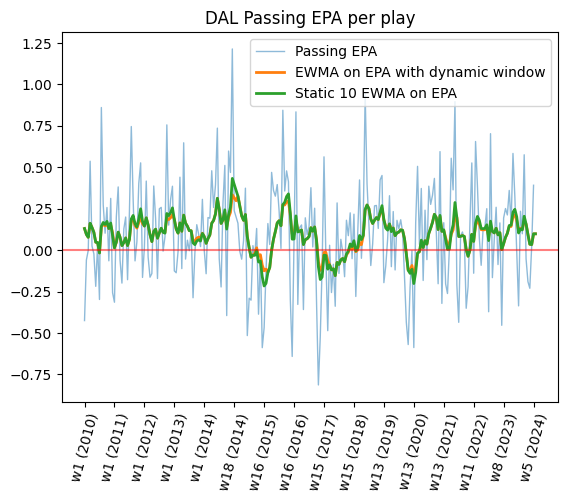

In [251]:
team = 'DAL'
tm = epa.loc[epa['team'] == team, :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) #rotate the x-axis labels a bit

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2);
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title(f'{team} Passing EPA per play')
plt.show()

### 2023 Season - EPA

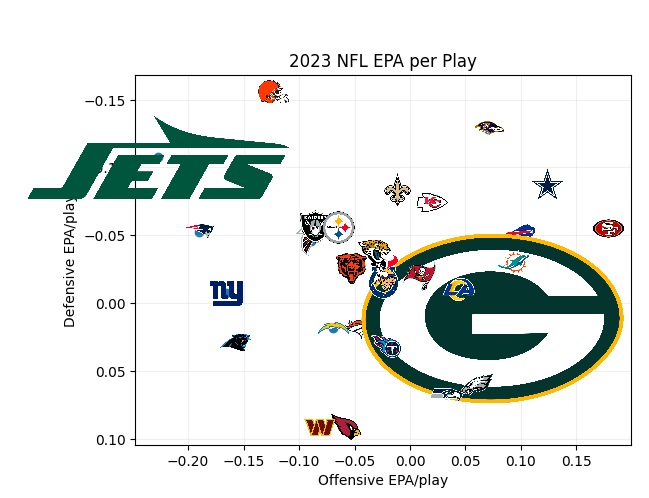

In [250]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


# Assuming nflreadr::load_pbp(2020) loads a pandas DataFrame
pbp_viz = pbp[(pbp['season'] == 2023) & (pbp['season_type'] == 'REG') & (pbp['posteam'].notna()) & ((pbp['rush'] == 1) | (pbp['pass'] == 1))] #(pbp['rz'] == 1) &

offense = pbp_viz.groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_epa'})
pass_offense = pbp_viz[pbp_viz['pass_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_pass_epa'})
run_offense = pbp_viz[pbp_viz['rush_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_run_epa'})
rz_offense =pbp_viz[pbp_viz['rz']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'rz_off_epa'})
non_rz_offense=pbp_viz[pbp_viz['rz']==0].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'non_rz_off_epa'})



defense = pbp_viz.groupby('defteam').agg({'epa': np.mean}).reset_index().rename(columns={'defteam': 'team', 'epa': 'def_epa'})

combined = pd.merge(offense, defense, on='team')

qbs = pbp_viz[(pbp_viz['pass'] == 1) | (pbp_viz['rush'] == 1) & pbp_viz['down'].isin(range(1, 5))].groupby('id').agg({
    'name': 'first',
    'posteam': 'last',
    'id': 'count',
    'qb_epa': np.mean
}).rename(columns={'id': 'plays', 'posteam': 'team'}).query('plays > 200').nlargest(10, 'qb_epa')

# Assuming that 'team_logos' is a dictionary with team names as keys and URLs/paths of logos as values
team_logos = teams.set_index('team_abbr')['team_logo_espn'].to_dict()

fig, ax = plt.subplots()
ax.scatter(combined['off_epa'], combined['def_epa'])

# Add logos to the plot
for x, y, team in zip(combined['off_epa'], combined['def_epa'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    # Create offset image
    oi = OffsetImage(img, zoom=0.05)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Offensive EPA/play')
ax.set_ylabel('Defensive EPA/play')
ax.set_title('2023 NFL EPA per Play')
ax.grid(alpha=0.2)
ax.invert_yaxis()
plt.show()

### Model sees - Offense EPA

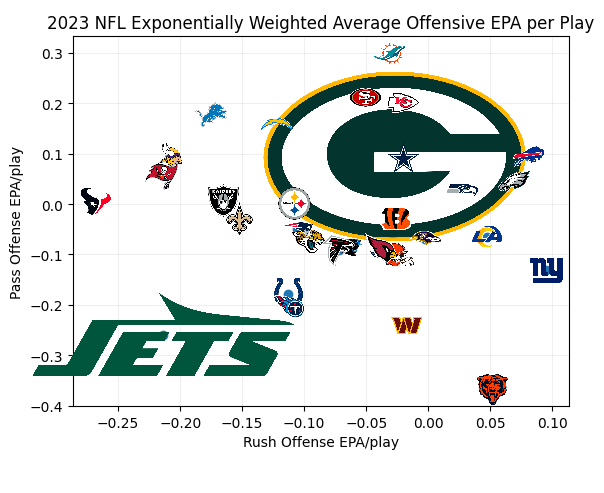

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


m = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['home_team', 'away_team'], value_name='team').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'team']]
m1 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_away'], value_name='ewma_rushing_offense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_rushing_offense']]
m2 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_passing_offense_home', 'ewma_dynamic_window_passing_offense_away'], value_name='ewma_passing_offense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_passing_offense']]
combined = pd.concat([m, m1['ewma_rushing_offense'], m2['ewma_passing_offense']], axis=1)

fig, ax = plt.subplots()
ax.scatter(combined['ewma_rushing_offense'], combined['ewma_passing_offense'])

# Add logos to the plot
for x, y, team in zip(combined['ewma_rushing_offense'], combined['ewma_passing_offense'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    # Create offset image
    oi = OffsetImage(img, zoom=0.05)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Rush Offense EPA/play')
ax.set_ylabel('Pass Offense EPA/play')
ax.set_title('2023 NFL Exponentially Weighted Average Offensive EPA per Play')
ax.grid(alpha=0.2)
#ax.invert_yaxis()
plt.show()

### Model sees - Defense EPA

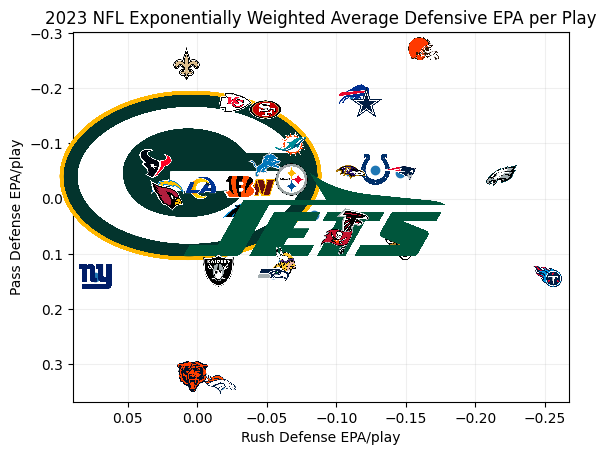

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


m = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['home_team', 'away_team'], value_name='team').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'team']]
m1 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_away'], value_name='ewma_rushing_defense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_rushing_defense']]
m2 = pd.melt(this_week, id_vars=['season', 'week'], value_vars=['ewma_dynamic_window_passing_defense_home', 'ewma_dynamic_window_passing_defense_away'], value_name='ewma_passing_defense').drop('variable', axis=1).reset_index(drop=True)[['season', 'week', 'ewma_passing_defense']]
combined = pd.concat([m, m1['ewma_rushing_defense'], m2['ewma_passing_defense']], axis=1)
fig, ax = plt.subplots()
ax.scatter(combined['ewma_rushing_defense'], combined['ewma_passing_defense'])

# Add logos to the plot
for x, y, team in zip(combined['ewma_rushing_defense'], combined['ewma_passing_defense'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    # Create offset image
    oi = OffsetImage(img, zoom=0.05)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Rush Defense EPA/play')
ax.set_ylabel('Pass Defense EPA/play')
ax.set_title('2023 NFL Exponentially Weighted Average Defensive EPA per Play')
ax.grid(alpha=0.2)
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

### 2023 Season - RZ Offense and Defense EPA

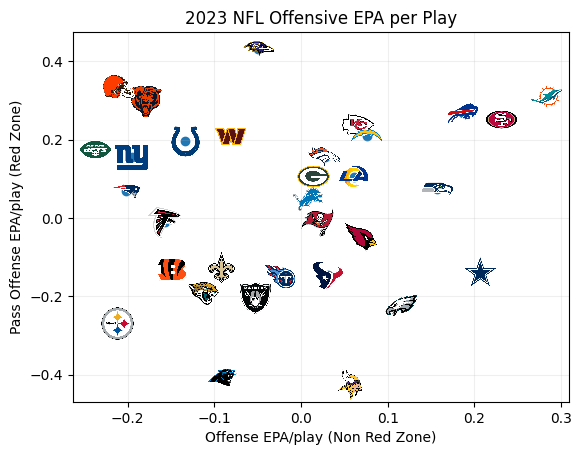

In [842]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


# Assuming nflreadr::load_pbp(2020) loads a pandas DataFrame
pbp_viz = pbp[(pbp['season'] == 2023) & (pbp['season_type'] == 'REG') & (pbp['posteam'].notna()) & ((pbp['rush'] == 1) | (pbp['pass'] == 1))] #(pbp['rz'] == 1) &

offense = pbp_viz.groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_epa'})
pass_offense = pbp_viz[pbp_viz['pass_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_pass_epa'})
run_offense = pbp_viz[pbp_viz['rush_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_run_epa'})
rz_offense =pbp_viz[pbp_viz['rz']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'rz_off_epa'})
non_rz_offense=pbp_viz[pbp_viz['rz']==0].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'non_rz_off_epa'})



defense = pbp_viz.groupby('defteam').agg({'epa': np.mean}).reset_index().rename(columns={'defteam': 'team', 'epa': 'def_epa'})

combined = pd.merge(rz_offense, non_rz_offense, on='team')

qbs = pbp_viz[(pbp_viz['pass'] == 1) | (pbp_viz['rush'] == 1) & pbp_viz['down'].isin(range(1, 5))].groupby('id').agg({
    'name': 'first',
    'posteam': 'last',
    'id': 'count',
    'qb_epa': np.mean
}).rename(columns={'id': 'plays', 'posteam': 'team'}).query('plays > 200').nlargest(10, 'qb_epa')

# Assuming that 'team_logos' is a dictionary with team names as keys and URLs/paths of logos as values
team_logos = teams.set_index('team_abbr')['team_logo_espn'].to_dict()

fig, ax = plt.subplots()
ax.scatter(combined['non_rz_off_epa'], combined['rz_off_epa'])

# Add logos to the plot
for x, y, team in zip(combined['non_rz_off_epa'], combined['rz_off_epa'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    # Create offset image
    oi = OffsetImage(img, zoom=0.05)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Offense EPA/play (Non Red Zone)')
ax.set_ylabel('Offense EPA/play (Red Zone)')
ax.set_title('2023 NFL Offensive EPA per Play')
ax.grid(alpha=0.2)
#ax.invert_yaxis()
plt.show()

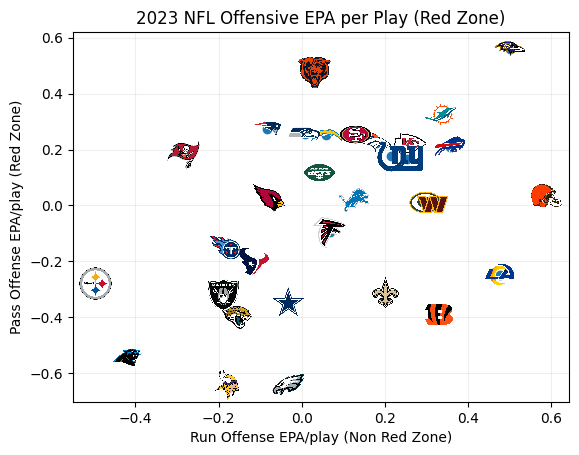

In [843]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import numpy as np


# Assuming nflreadr::load_pbp(2020) loads a pandas DataFrame
pbp_viz = pbp[(pbp['rz'] == 1) & (pbp['season'] == 2023) & (pbp['season_type'] == 'REG') & (pbp['posteam'].notna()) & ((pbp['rush'] == 1) | (pbp['pass'] == 1))] #(pbp['rz'] == 1) &

offense = pbp_viz.groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_epa'})
pass_offense = pbp_viz[pbp_viz['pass_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_pass_epa'})
run_offense = pbp_viz[pbp_viz['rush_attempt']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'off_run_epa'})
rz_offense =pbp_viz[pbp_viz['rz']==1].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'rz_off_epa'})
non_rz_offense=pbp_viz[pbp_viz['rz']==0].groupby('posteam').agg({'epa': np.mean}).reset_index().rename(columns={'posteam': 'team', 'epa': 'non_rz_off_epa'})



defense = pbp_viz.groupby('defteam').agg({'epa': np.mean}).reset_index().rename(columns={'defteam': 'team', 'epa': 'def_epa'})

combined = pd.merge(run_offense, pass_offense, on='team')

qbs = pbp_viz[(pbp_viz['pass'] == 1) | (pbp_viz['rush'] == 1) & pbp_viz['down'].isin(range(1, 5))].groupby('id').agg({
    'name': 'first',
    'posteam': 'last',
    'id': 'count',
    'qb_epa': np.mean
}).rename(columns={'id': 'plays', 'posteam': 'team'}).query('plays > 200').nlargest(10, 'qb_epa')

# Assuming that 'team_logos' is a dictionary with team names as keys and URLs/paths of logos as values
team_logos = teams.set_index('team_abbr')['team_logo_espn'].to_dict()

fig, ax = plt.subplots()
ax.scatter(combined['off_run_epa'], combined['off_pass_epa'])

# Add logos to the plot
for x, y, team in zip(combined['off_run_epa'], combined['off_pass_epa'], combined['team']):
    # Read image from URL
    with urllib.request.urlopen(team_logos[team]) as url:
        img = Image.open(url)
        img = np.array(img)
    # Create offset image
    oi = OffsetImage(img, zoom=0.05)
    # Create annotation box
    ab = AnnotationBbox(oi, (x, y), frameon=False)
    # Add annotation box to the axes
    ax.add_artist(ab)
    
ax.set_xlabel('Run Offense EPA/play (Non Red Zone)')
ax.set_ylabel('Pass Offense EPA/play (Red Zone)')
ax.set_title('2023 NFL Offensive EPA per Play (Red Zone)')
ax.grid(alpha=0.2)
#ax.invert_yaxis()
plt.show()

# Export data to endpoint

In [325]:
import json

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, pd.DataFrame):
            return obj.to_dict('records')
        else:
            return super(MyEncoder, self).default(obj)
        
season_results_json_string = json.dumps(season_results, cls=MyEncoder)

picks_json_string = json.dumps(plays[['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'away_score_pred', 
          'spread_pred', 'spread_line',  'spread_play', 'spread_win_prob', 'spread_lock' ,'total_pred', 'total_line', 'total_play', 'total_win_prob', 'total_lock']], cls=MyEncoder)

In [326]:
file_path = file_path = "/Users/wiboyd/Desktop/Misc/Sports Betting/sports_betting_azure/nfl-weekly-picks-wb/get-json-picks/__init__.py"
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[19] = "'" +picks_json_string + "'"+ '\n'
lines[27] = "'" +season_results_json_string + "'"+ '\n'  # replace line 27 (index 28) with the JSON string

# Open the file in write mode and write the modified lines back to it


with open(file_path, 'w') as file:
    file.writelines(lines)

# Save picks

In [160]:
from datetime import datetime

gs_df = plays[['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'away_score_pred', 
          'spread_pred', 'spread_line',  'spread_play', 'spread_win_prob', 'spread_lock',
          'total_pred', 'total_line', 'total_play', 'total_win_prob', 'total_lock']].copy()

gs_df['spread_win'] = -1
gs_df['total_win'] = -1
gs_df['input_date'] = datetime.today().strftime('%Y-%m-%d')


creds = Credentials.from_service_account_file('/Users/wiboyd/Desktop/Misc/Sports Betting/google_api/wb-sports-analytics-9b7e566c97ff.json')
spreadsheet_id = '1CRIv7qg340veGOJuwcFW67ClvP9ADJKfzgQzB-lSrjs'
service = build('sheets', 'v4', credentials=creds)
sheet = service.spreadsheets()


In [162]:
def update_df(df_sheet, inputs_wins):
    df_sheet['spread_win'] = df_sheet['spread_win'].replace('-1', -1).astype(int)
    df_sheet['total_win'] = df_sheet['total_win'].replace('-1', -1).astype(int)
    df_sheet['season'] = df_sheet['season'].astype(int)
    df_sheet['week'] = df_sheet['week'].astype(int)
    
    for idx, row in df_sheet.iterrows():
        # Find matching row in inputs_wins
        match = inputs_wins.loc[
            (inputs_wins['season'] == row['season']) & 
            (inputs_wins['week'] == row['week']) & 
            (inputs_wins['home_team'] == row['home_team']) & 
            (inputs_wins['away_team'] == row['away_team'])
        ]
        
        if len(match) > 0:
            # If match found, update spread_win and total_win in df_sheet
            if row['spread_win'] == -1 and row['spread_play'] == match.iloc[0]['correct_spread_play']:
                df_sheet.at[idx, 'spread_win'] = 1
            if row['spread_win'] == -1 and row['spread_play'] != match.iloc[0]['correct_spread_play']:
                df_sheet.at[idx, 'spread_win'] = 0
            if row['total_win'] == -1 and row['total_play'] == match.iloc[0]['correct_total_play']:
                df_sheet.at[idx, 'total_win'] = 1
            if row['total_win'] == -1 and row['total_play'] != match.iloc[0]['correct_total_play']:
                df_sheet.at[idx, 'total_win'] = 0

    return df_sheet

## Append picks to df

In [156]:
gs_data = gs_df.values.tolist()


request = sheet.values().append(spreadsheetId=spreadsheet_id, 
                                range='Sheet1', # Adjust this as needed
                                valueInputOption='USER_ENTERED', 
                                body={'values': gs_data},
                                insertDataOption='INSERT_ROWS')


# response = request.execute()
# print(response)

{'spreadsheetId': '1CRIv7qg340veGOJuwcFW67ClvP9ADJKfzgQzB-lSrjs', 'tableRange': 'Sheet1!A1:S91', 'updates': {'spreadsheetId': '1CRIv7qg340veGOJuwcFW67ClvP9ADJKfzgQzB-lSrjs', 'updatedRange': 'Sheet1!A92:S105', 'updatedRows': 14, 'updatedColumns': 19, 'updatedCells': 266}}


## Update picks with win results

In [165]:
inputs_wins = season_results[8]['df'].copy()

result = sheet.values().get(spreadsheetId=spreadsheet_id, range="Sheet1").execute()
values = result.get('values', [])

# Convert the fetched data to a DataFrame
headers = values.pop(0)
df_sheet = pd.DataFrame(values, columns=headers)

df_sheet = update_df(df_sheet, inputs_wins)

gs_data = [df_sheet.columns.tolist()] + df_sheet.values.tolist()


# Write the updated data back to the sheet
request = sheet.values().update(spreadsheetId=spreadsheet_id, 
                                range='Sheet1!A1', # Adjust this as needed
                                valueInputOption='USER_ENTERED', 
                                body={'values': gs_data})
response = request.execute()
print(response)

{'spreadsheetId': '1CRIv7qg340veGOJuwcFW67ClvP9ADJKfzgQzB-lSrjs', 'updatedRange': 'Sheet1!A1:S105', 'updatedRows': 105, 'updatedColumns': 19, 'updatedCells': 1995}


## Create new sheet with columns

In [263]:
gs_data = [gs_df.columns.tolist()] + gs_df.values.tolist()

request = sheet.values().update(spreadsheetId=spreadsheet_id, 
                                range='Sheet1!A1', # Adjust this as needed
                                valueInputOption='USER_ENTERED', 
                                body={'values': gs_data})

# response = request.execute()
# print(response)

{'spreadsheetId': '1CRIv7qg340veGOJuwcFW67ClvP9ADJKfzgQzB-lSrjs', 'updatedRange': 'Sheet1!A1:S17', 'updatedRows': 17, 'updatedColumns': 19, 'updatedCells': 323}


# Save model

In [1016]:
from joblib import dump

# assuming 'model' is your trained model
#dump(home_model, f'./Models/2023_week_{current_week}_home_model.joblib') 
#dump(away_model, f'./Models/2023_week_{current_week}_away_model.joblib')
#dump(spread_clf, f'./Models/2023_week_{current_week}_spread_lock_model.joblib') 
#dump(total_clf, f'./Models/2023_week_{current_week}_total_lock_model.joblib')

['./Models/2023_week_6_spread_lock_model.joblib']

## Load in previous model

In [1011]:
from joblib import load

# assuming 'model' is your trained model
home_model = load('./Models/2023_week_4_home_model.joblib') 
away_model = load('./Models/2023_week_4_away_model.joblib')
spread_clf = load('./Models/2023_week_4_spread_lock_model.joblib') 
total_clf = load('./Models/2023_week_4_total_lock_model.joblib')

this_week = df[(df['season'] == 2023) & (df['week'] == 4)]
this_week[ewma_features] = np.nan
this_week = this_week = this_week[~this_week['home_score'].notnull()]
this_week_away_scores = away_model.predict(this_week[features])
this_week_home_scores = home_model.predict(this_week[features])
this_week_predicted_spreads = this_week_home_scores - this_week_away_scores
#plays = this_week.copy()
plays['away_score_pred'] = this_week_away_scores
plays['home_score_pred'] = this_week_home_scores
plays['spread_pred']= this_week_predicted_spreads
plays['total_pred'] = this_week_away_scores + this_week_home_scores
plays['spread_play'] = plays.apply(lambda row: row['away_team'] if row['spread_pred'] < row['spread_line'] else row['home_team'], axis=1)
plays['total_play'] = plays.apply(lambda row: 'under' if row['total_pred'] < row['total_line'] else ('over' if row['total_pred'] > row['total_line'] else None), axis=1)
plays['spread_win_prob'] = win_probability(plays, classifier = spread_clf, features = spread_class_features)
plays['total_win_prob'] = win_probability(plays, classifier = total_clf, features = total_class_features)
plays = best_plays(plays, 5)
plays[['season', 'week', 'home_team', 'away_team', 'home_score_pred', 'away_score_pred', 
          'spread_pred', 'spread_line',  'spread_play', 'spread_win_prob', 'spread_lock', 'total_pred', 'total_line', 'total_play', 'total_win_prob', 'total_lock']]

FileNotFoundError: [Errno 2] No such file or directory: './Models/2023_week_4_total_lock_model.joblib'

In [595]:
spread_1 = plays['spread_play']
total_1 = plays['total_play']

In [599]:
spread_2 = plays['spread_play']
total_2 = plays['total_play']

In [600]:
set(spread_2) - set(spread_1)

{'BAL', 'DEN', 'LA', 'MIN', 'SF'}

# Scratch

In [ ]:
#def win_probability(plays, historical, noise_parameter = 10): 


#     #Spread win percentage
#     historical['spread_error'] = round(historical['spread_pred'] - historical['spread_line'])
#     plays['spread_error'] = round(plays['spread_pred'] - plays['spread_line'])
#     spread_win_rate = historical.groupby('spread_error')['spread_win'].mean()
#     n_games = historical.groupby('spread_error').size()
#     overall_spread_win_rate = historical['spread_win'].mean()
#     spread_win_rate_smoothed = (spread_win_rate*n_games + overall_spread_win_rate*noise_parameter) / (n_games + noise_parameter)
#     spread_win_prob = plays['spread_error'].map(spread_win_rate_smoothed) * 100.0

#     #Total win percentage
#     historical['total_error'] = round(historical['total_pred'] - historical['total_line'])
#     plays['total_error'] = round(plays['total_pred'] - plays['total_line'])
#     total_win_rate = historical.groupby('total_error')['total_win'].mean()
#     n_games = historical.groupby('total_error').size()
#     overall_spread_win_rate = historical['total_win'].mean()
#     spread_win_rate_smoothed = (total_win_rate*n_games + overall_spread_win_rate*noise_parameter) / (n_games + noise_parameter)
#     total_win_prob = plays['total_error'].map(spread_win_rate_smoothed) * 100.0

#     return {'spread_win_prob': spread_win_prob, 'total_win_prob': total_win_prob}

# plays['spread_win_prob'] = win_probability(plays, results)['spread_win_prob']
# plays['total_win_prob'] = win_probability(plays, results)['total_win_prob']